In [8]:
import torch
print(torch.cuda.is_available())

True


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Read data
data = pd.read_csv("https://raw.githubusercontent.com/sreckojoksimovic/infs5100/main/wine-data.csv")
data['quality_class'] = data['quality_class'].astype('category')
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_class
0,7.3,0.65,0.00,1.2,0.065,15,21,0.9946,3.39,0.47,10.0,1
1,7.8,0.58,0.02,2.0,0.073,9,18,0.9968,3.36,0.57,9.5,1
2,8.5,0.28,0.56,1.8,0.092,35,103,0.9969,3.30,0.75,10.5,1
3,8.1,0.38,0.28,2.1,0.066,13,30,0.9968,3.23,0.73,9.7,1
4,7.5,0.52,0.16,1.9,0.085,12,35,0.9968,3.38,0.62,9.5,1


In [7]:
# Define numeric_vars as all columns except 'quality_class'
numeric_vars = [col for col in data.columns if col != 'quality_class']

# Preprocess data
X = data[numeric_vars].values
y = data['quality_class'].cat.codes.values

# Split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define Logistic Regression model
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(X_train.shape[1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

# Create DataLoader
train_data = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Train the model
model = LogisticRegression()
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1000):
    for batch_X, batch_y in train_loader:
        y_pred = model(batch_X)
        loss = loss_function(y_pred, batch_y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Test the model
with torch.no_grad():
    y_pred = model(torch.FloatTensor(X_test))
    y_pred_class = (y_pred > 0.5).float()
    accuracy = (y_pred_class.squeeze() == torch.FloatTensor(y_test)).float().mean()
    print(f'Accuracy: {accuracy.item()}')


Accuracy: 0.8633405566215515


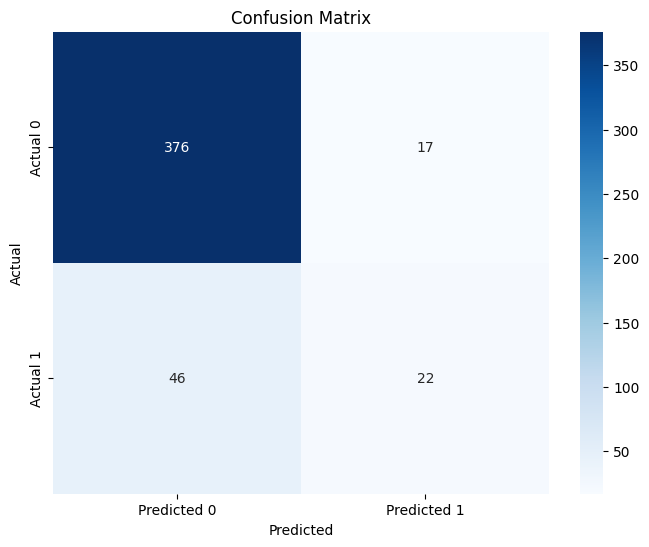

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
y_test_tensor = torch.FloatTensor(y_test)
conf_matrix = confusion_matrix(y_test_tensor, y_pred_class.squeeze())

# Plot confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [13]:
# Define device (use CUDA if available, otherwise use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
# Move model to device
model.to(device)

# Train the model
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1000):
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device) # Move data to device
        y_pred = model(batch_X)
        loss = loss_function(y_pred, batch_y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Test the model
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test).to(device) # Move test data to device
    y_pred = model(X_test_tensor)
    y_pred_class = (y_pred > 0.5).float()
    y_pred_class = y_pred_class.cpu() # Move back to CPU for further calculations
    accuracy = (y_pred_class.squeeze() == torch.FloatTensor(y_test)).float().mean()
    print(f'Accuracy: {accuracy.item()}')


Accuracy: 0.8633405566215515


In [14]:
torch.cuda.empty_cache()